# Capstone project: finding right place to place italian restaurant in NYC

### 1. Preparation

In [1]:
# Import required libraries
from bs4 import BeautifulSoup
import requests
import json
import lxml
import pandas as pd
import numpy as np
import folium
import geocoder # import geocoder
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import matplotlib.cm as cm
import matplotlib.colors as colors
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


# Solving project problems

In [3]:
# load prepared dataset
results_dataset = pd.read_csv('final_results.csv')

In [5]:
results_dataset.head()

,Borough,Neighborhood,Venue_name,Venue_id,Venue_lat,Venue_lng,PriceTier,LikesCount,Dislike,Rating,BeenHereCount,PhotosCount,ReasonsCount,TipsCount
0,Bronx,Fieldston,Salvatore's of Soho,4c6994e3c946e21eb28eea8e,40.887633,-73.907178,2,77,False,8.1,0,72,1,34
1,Bronx,Fieldston,Caffe Buon Gusto - Bronx,56787589498eca7da2a82944,40.889328,-73.900085,0,0,False,0.0,0,5,0,0
2,Bronx,Fieldston,Riverdale Market,4d95272d744f3704e4889a57,40.891607,-73.897834,0,2,False,0.0,0,0,0,3
3,Bronx,Riverdale,Bella Notte Pizzeria,55aaee4d498e3cbb70e625d6,40.886595,-73.909556,0,9,False,7.1,0,2,0,4
4,Bronx,Riverdale,Mr. Nicks Pizza & Pasta,511b54f17ab47b5a3cc69aec,40.886471,-73.909492,0,1,False,0.0,0,5,0,6


In [6]:
results_dataset.shape

(1652, 14)

### Defined problems:
1. Best italian restaurants - find (based on rating? tips? price tier?), visualize
2. Where are most of best restaurans?
3. Which area has some problems with restaurants?
4. Where you should stay if you want to have best restraurants borough?

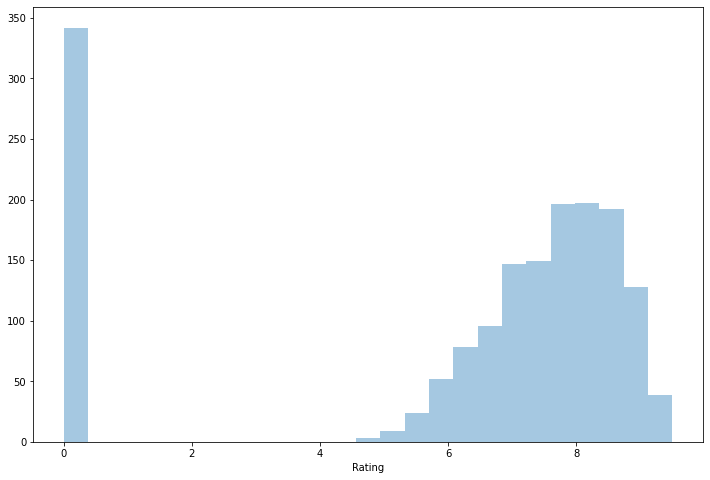

In [7]:
plt.figure(figsize=(12,8))
sns.distplot(results_dataset.Rating, kde=False)

In [8]:
results_dataset.corr()['Rating']

Venue_lat        0.096350
Venue_lng        0.033112
PriceTier        0.214459
LikesCount       0.270598
Dislike               NaN
Rating           1.000000
BeenHereCount         NaN
PhotosCount      0.218819
ReasonsCount     0.601545
TipsCount        0.312443
Name: Rating, dtype: float64

In [9]:
results_dataset.corr('spearman')['Rating']

Venue_lat        0.007991
Venue_lng       -0.023467
PriceTier        0.187979
LikesCount       0.792254
Dislike               NaN
Rating           1.000000
BeenHereCount         NaN
PhotosCount      0.686267
ReasonsCount     0.649569
TipsCount        0.711472
Name: Rating, dtype: float64

# Problem #1

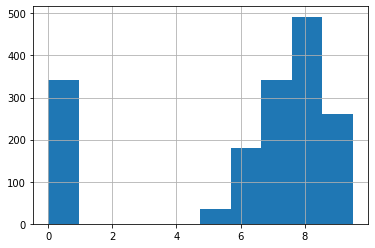

In [10]:
results_dataset.Rating.hist()

In [11]:
results_dataset.Rating.describe()

count    1652.000000
mean        6.072276
std         3.217964
min         0.000000
25%         5.900000
50%         7.400000
75%         8.200000
max         9.500000
Name: Rating, dtype: float64

Max score is 9.5, third quantile is about 8.2 - but we are interested in about 10% of them, of best ones (that will be about 160 restaurants)

In [12]:
results_dataset.Rating.quantile(0.9)

8.8

So restaurants with scoring higher than 8.8 

In [13]:
best_restaurans = results_dataset[results_dataset.Rating >= 8.8]

In [14]:
best_restaurans.shape

(167, 14)

In [15]:
best_restaurans.head()

,Borough,Neighborhood,Venue_name,Venue_id,Venue_lat,Venue_lng,PriceTier,LikesCount,Dislike,Rating,BeenHereCount,PhotosCount,ReasonsCount,TipsCount
22,Bronx,Pelham Parkway,John & Joe's Pizzeria,4bc78c0d0050b71372e8b83b,40.854520,-73.865824,1,47,False,8.8,0,28,1,27
25,Bronx,Pelham Parkway,Ann Clair's Salumeria,4ae0c38ef964a5203d8221e3,40.850046,-73.851796,1,51,False,8.9,0,41,1,20
37,Bronx,Fordham,Tino's Delicatessen,4acf80aef964a52025d420e3,40.855882,-73.887166,1,145,False,9.3,0,77,1,48
38,Bronx,Fordham,Zero Otto Nove,4aabd3e6f964a5204a5a20e3,40.854714,-73.888388,3,232,False,8.8,0,146,1,78
40,Bronx,Fordham,Calabria Pork Store,4bb6470cef159c7465b275f7,40.854145,-73.888776,0,30,False,8.9,0,54,0,13


In [16]:
state_geo = f'nyc_neighborhoods.geojson'

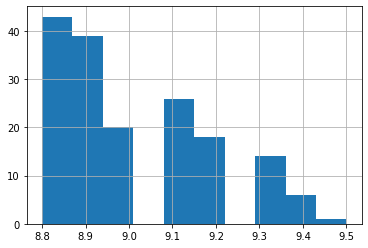

In [17]:
best_restaurans.Rating.hist()

Let's prepare some rules abou colors - every 0.2 there should be different colors used

In [18]:
m = folium.Map(location=[latitude, longitude], zoom_start=13, tiles='cartodbpositron')

In [19]:
for lat, lng, name, neighborhood, rating in zip(best_restaurans['Venue_lat'], 
                                                   best_restaurans['Venue_lng'], 
                                                   best_restaurans['Venue_name'], 
                                                   best_restaurans['Neighborhood'], 
                                                   best_restaurans['Rating']):
    label = '\"{}\" at {}; Rating: {}'.format(name, neighborhood, rating)
    label = folium.Popup(label, parse_html=True)
    clr = 'none'
    if rating <= 9.0:
        clr = 'cornflowerblue'
    elif rating > 9.0 and rating <= 9.2:
        clr = 'royalblue'
    elif rating > 9.2 and rating < 9.4:
        clr = 'mediumblue'
    elif rating >= 9.4:
        clr = 'navy'
    
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=clr,
        fill=True,
        fill_opacity=0.8,
        parse_html=False).add_to(m)  
    

In [20]:
m

### Results for problem #1 and #2

So, we already know where they are - most of them are on Manhattan, but the best one - with few additional strong ones are in Ford Green

Take a look into distrubtions of them among price tiers

In [21]:
best_restaurans.PriceTier.value_counts()

2    76
3    32
1    30
0    22
4     7
Name: PriceTier, dtype: int64

Most middle-priced, only few withing this higher range 

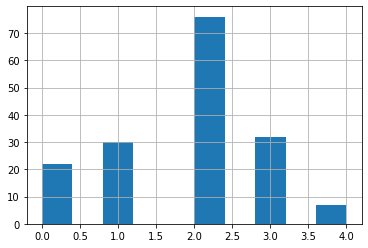

In [22]:
best_restaurans.PriceTier.hist()

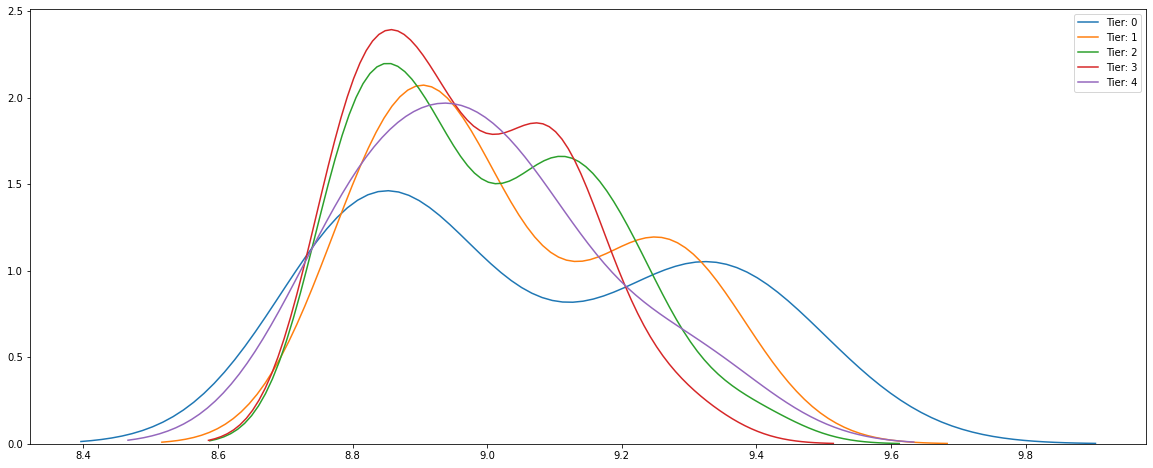

In [23]:
plt.figure(figsize=(20,8))
for val in sorted(best_restaurans.PriceTier.unique()):
    sns.kdeplot(best_restaurans[best_restaurans.PriceTier == val].Rating, label=f'Tier: {val}')

In [24]:
best_restaurans.corr()['Rating']

Venue_lat       -0.159142
Venue_lng        0.006111
PriceTier       -0.156807
LikesCount       0.167386
Dislike               NaN
Rating           1.000000
BeenHereCount         NaN
PhotosCount      0.124594
ReasonsCount     0.102418
TipsCount        0.124372
Name: Rating, dtype: float64

We see there that cheapest ones has even better scoring, but take a look into raw numbers

In [25]:
best_restaurans.sort_values(by='Rating', ascending=False).head(10)

,Borough,Neighborhood,Venue_name,Venue_id,Venue_lat,Venue_lng,PriceTier,LikesCount,Dislike,Rating,BeenHereCount,PhotosCount,ReasonsCount,TipsCount
382,Brooklyn,Fort Greene,Mekelburg's,557dae53498ed2645c3ebbc0,40.687571,-73.962370,0,368,False,9.5,0,182,1,56
455,Brooklyn,East Williamsburg,Lella Alimentari,56055323498e16b73108b749,40.715133,-73.946342,1,209,False,9.4,0,98,1,45
355,Brooklyn,Gowanus,L'Albero dei gelati,51e88628498e357b8f4779e2,40.671977,-73.983767,2,273,False,9.4,0,176,1,98
249,Brooklyn,Williamsburg,L'Industrie Pizzeria,55135426498e9dee8f19cc5f,40.711675,-73.957697,0,126,False,9.4,0,70,1,32
268,Brooklyn,Bushwick,Carmenta’s,5a98aed16a59506d7a60d67c,40.701320,-73.926783,0,58,False,9.4,0,31,1,21
1064,Manhattan,West Village,Faicco's Italian Specialties,4a74a36af964a520fede1fe3,40.731117,-74.003043,2,332,False,9.4,0,221,1,121
363,Brooklyn,Fort Greene,Evelina Restaurant,5a00f3538496ca58fd9e2856,40.689629,-73.971018,0,192,False,9.4,0,72,1,34
345,Brooklyn,Carroll Gardens,Court Street Grocers,4c5dbf402815c928c8c3b567,40.676287,-73.998807,0,460,False,9.3,0,331,1,153
721,Manhattan,Lincoln Square,Marea,4a0babaaf964a52007751fe3,40.767452,-73.981114,4,1011,False,9.3,0,1388,1,350
1099,Manhattan,Gramercy,Eataly Flatiron,4c5ef77bfff99c74eda954d3,40.741987,-73.989913,0,8136,False,9.3,0,7568,1,1484


In [26]:
best_restaurans.describe()

,Venue_lat,Venue_lng,PriceTier,LikesCount,Rating,BeenHereCount,PhotosCount,ReasonsCount,TipsCount
count,167.000000,167.000000,167.000000,167.00000,167.000000,167.0,167.000000,167.000000,167.000000
mean,40.724610,-73.975469,1.832335,496.94012,9.004790,0.0,366.874251,0.982036,151.562874
std,0.054295,0.045103,1.021767,813.98177,0.182951,0.0,860.438122,0.133220,202.176755
min,40.572256,-74.140226,0.000000,22.00000,8.800000,0.0,8.000000,0.000000,2.000000
25%,40.697489,-73.998453,1.000000,118.00000,8.800000,0.0,60.500000,1.000000,38.000000
50%,40.725264,-73.984915,2.000000,292.00000,9.000000,0.0,147.000000,1.000000,97.000000
75%,40.742706,-73.956447,2.000000,599.50000,9.100000,0.0,370.000000,1.000000,191.500000
max,40.855882,-73.828785,4.000000,8136.00000,9.500000,0.0,7568.000000,1.000000,1484.000000


So, there are not information about Been Here Count, there are some information about likes, rating, tips; most valuable for us should be likes count, mean and median values for each neighborhood

In [27]:
best_restaurans.groupby(['Neighborhood']).agg({'LikesCount': ['mean', 'median', 'sum'], 'Rating': ['mean', 'median']}).reset_index().sort_values(by=('Rating', 'median'), ascending=False).head(10)

Neighborhood   LikesCount                  Rating       
                               mean  median   sum      mean median
56        Williamsburg   553.000000   172.0  1659  9.233333    9.3
18   East Williamsburg   901.250000   151.5  3605  9.275000    9.3
1   Bedford Stuyvesant   745.000000   745.0   745  9.200000    9.2
3          Bensonhurst   118.500000   118.5   237  9.200000    9.2
49   Sunnyside Gardens    44.000000    44.0    44  9.200000    9.2
47    Prospect Heights   407.000000   368.0  1221  9.066667    9.2
22         Fort Greene   354.800000   292.0  1774  9.220000    9.2
24             Gowanus   156.333333   148.0   469  9.166667    9.2
27           Gravesend  1107.000000  1107.0  1107  9.200000    9.2
11        Clinton Hill   831.000000   831.0   831  9.200000    9.2

Our results is that area of Williamsburg has best from the best ones Italian resuturants 

### Solution for problem #3

In [28]:
unique_borough = results_dataset.Borough.unique()

In [29]:
unique_borough

array(['Bronx', 'Manhattan', 'Brooklyn', 'Queens', 'Staten Island'],
      dtype=object)

In [30]:
results_dataset.groupby(['Borough']).agg({'Rating': ['count', 'mean']}).reset_index().sort_values(by=('Rating', 'mean'), ascending=True).head(30)

Borough Rating          
                  count      mean
4  Staten Island     94  3.625532
0          Bronx    124  5.195161
3         Queens    116  5.287931
1       Brooklyn    393  6.163104
2      Manhattan    925  6.498270

In [31]:
best_restaurans.groupby(['Borough']).agg({'Rating': ['count', 'mean', 'median']}).reset_index()

Borough Rating                 
                  count      mean median
0          Bronx     10  8.900000   8.90
1       Brooklyn     56  9.071429   9.10
2      Manhattan     88  8.977273   8.90
3         Queens      8  8.987500   8.95
4  Staten Island      5  8.980000   9.00

So - biggest problem has Staten Island - overall mean and median values for ratings are very low, like also number of neighborhoods with 0.0 rating is high - but also there are only few restaurants in this areas.

### Solution for problem #4

In [36]:
results_dataset.head(1)

,Borough,Neighborhood,Venue_name,Venue_id,Venue_lat,Venue_lng,PriceTier,LikesCount,Dislike,Rating,BeenHereCount,PhotosCount,ReasonsCount,TipsCount
0,Bronx,Fieldston,Salvatore's of Soho,4c6994e3c946e21eb28eea8e,40.887633,-73.907178,2,77,False,8.1,0,72,1,34


In [37]:
results_dataset.groupby(['Borough']).agg({'Rating': ['count', 'mean', 'median']}).reset_index()

Borough Rating                 
                  count      mean median
0          Bronx    124  5.195161   7.10
1       Brooklyn    393  6.163104   7.50
2      Manhattan    925  6.498270   7.40
3         Queens    116  5.287931   7.15
4  Staten Island     94  3.625532   0.00

In [38]:
best_restaurans.groupby(['Borough']).agg({'Rating': ['count', 'mean', 'median']}).reset_index()

Borough Rating                 
                  count      mean median
0          Bronx     10  8.900000   8.90
1       Brooklyn     56  9.071429   9.10
2      Manhattan     88  8.977273   8.90
3         Queens      8  8.987500   8.95
4  Staten Island      5  8.980000   9.00

So, we see there that there is one borough that has slighly better score - let's take a deeper dive into that result - so check Brooklyn.